# Exploratory Analysis: IMDb Dataset and Sentiment Reward Model

This notebook performs the initial exploratory analysis required for the RLHF project.  
The objectives of this analysis are:

- Load and examine the IMDb dataset  
- Load the reward model used for sentiment scoring  
- Implement a scoring function that will be used during PPO training  
- Visualize the reward distribution on real data samples  
- Verify GPU functionality and model inference stability  

This exploration establishes the baseline behavior of the reward model prior to supervised fine-tuning and RLHF.


In [1]:
#!pip install datasets transformers trl accelerate sentencepiece evaluate matplotlib -q

### Overview of Dependencies

The libraries imported below provide the essential components for data processing, model loading, and visualization:

- **datasets** — for loading the IMDb dataset  
- **transformers** — for tokenizers, pretrained models, and reward model inference  
- **torch** — tensor operations and GPU execution  
- **matplotlib** — visualizing reward distributions  

These tools will form the core of our RLHF training and evaluation pipeline.


In [2]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
import numpy as np


### IMDb Dataset Description

The IMDb dataset contains 50,000 movie reviews labeled as either *positive* or *negative*.  
It is well-structured, balanced, and widely used in sentiment classification research.

This dataset will serve two purposes in the overall project:

1. **Supervised Fine-Tuning (SFT)** — to train GPT-2 on coherent review-style text  
2. **Prompt Source for PPO** — PPO will generate completions based on review beginnings or short prompts

At this stage, we simply load the dataset and inspect its structure.


In [3]:
imdb = load_dataset("imdb")
imdb

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

### Inspecting Sample Reviews

Before training or reward computation, it is useful to examine a few raw examples to confirm dataset quality and text characteristics.  
This also provides intuition about the type of outputs that the language model will later be expected to generate.


In [4]:
print("Positive example:\n", imdb['train'][0]['text'][:300], "\n")
print("Negative example:\n", imdb['train'][1]['text'][:300])

Positive example:
 I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really h 

Negative example:
 "I Am Curious: Yellow" is a risible and pretentious steaming pile. It doesn't matter what one's political views are because this film can hardly be taken seriously on any level. As for the claim that frontal male nudity is an automatic NC-17, that isn't true. I've seen R-rated films with male nudity


### Sentiment Reward Model

For this project, sentiment feedback is obtained using a pretrained DistilBERT sentiment classifier:

**Model:** `lvwerra/distilbert-imdb`

The model outputs two logits:
- **logit[0]** → negative sentiment  
- **logit[1]** → positive sentiment  

These logits will serve as the reward signals when training PPO-based RLHF agents.  
Two separate agents will be trained:

- A *positive-sentiment-maximizing* agent  
- A *negative-sentiment-maximizing* agent  

At this stage, the goal is to confirm that the reward model loads correctly and produces sensible scores.


In [5]:
reward_model_name = "lvwerra/distilbert-imdb"
rm_tokenizer = AutoTokenizer.from_pretrained(reward_model_name)
rm_model = AutoModelForSequenceClassification.from_pretrained(reward_model_name)
rm_model.cuda();


In [6]:
import torch
torch.__version__

'2.9.1+cu128'

### Reward Computation Function

The following function runs the reward model on an input string and returns the raw sentiment logits.  
This function will be reused during both PPO training and post-training evaluation.

The purpose here is to ensure:
- Tokenization behaves correctly  
- GPU execution is functioning  
- The reward model provides stable and interpretable outputs  


In [7]:
def compute_reward(text):
    inputs = rm_tokenizer(text, return_tensors="pt", truncation=True, padding=True).to("cuda")
    with torch.no_grad():
        logits = rm_model(**inputs).logits
    return logits[0].cpu().numpy()

### Scoring Example Reviews

To validate reward model behavior, we compute sentiment logits on a small set of real IMDb samples.  
This confirms that:

- Model inference executes successfully  
- Output logits align with the expected sentiment of the text  
- No numerical or GPU-related issues are present  

This verification step is essential before integrating the reward function into PPO.


In [8]:
samples = [imdb['train'][i]['text'] for i in [0, 1, 2, 3, 4]]
scores = [compute_reward(t) for t in samples]

for i, s in enumerate(scores):
    print(f"Sample {i} Reward logits:", s)

Sample 0 Reward logits: [ 0.43966663 -0.7131735 ]
Sample 1 Reward logits: [ 2.2220936 -2.6400213]
Sample 2 Reward logits: [ 2.2590435 -2.674694 ]
Sample 3 Reward logits: [ 1.489021  -1.9037087]
Sample 4 Reward logits: [ 2.357368 -2.768199]


### Reward Distribution on IMDb Samples

To understand how the reward model evaluates natural text before any fine-tuning or RLHF,  
we compute positive-sentiment logits for a subset of the IMDb training set and plot their distribution.

This distribution will serve as an important **baseline reference** during later stages of the project:

- After supervised fine-tuning  
- After PPO-positive alignment  
- After PPO-negative alignment  

Comparing these distributions will clearly demonstrate how RLHF reshapes the sentiment behavior of GPT-2.


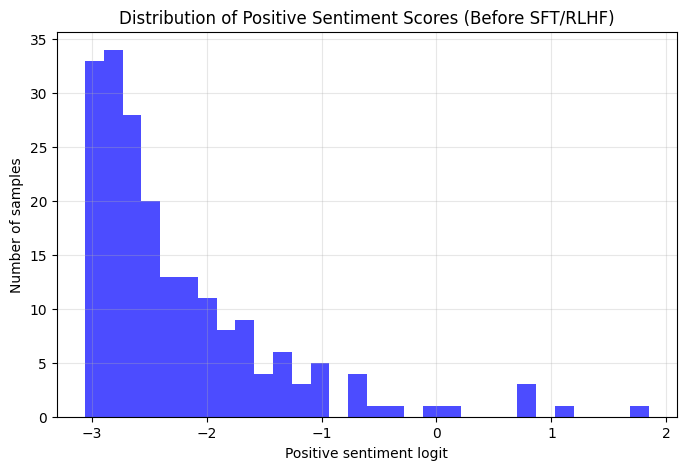

In [9]:
texts = [imdb['train'][i]['text'] for i in range(200)]
pos_scores = []

for t in texts:
    logits = compute_reward(t)
    pos_scores.append(logits[1])   # positive logit

pos_scores = np.array(pos_scores)

plt.figure(figsize=(8, 5))
plt.hist(pos_scores, bins=30, alpha=0.7, color='blue')
plt.title("Distribution of Positive Sentiment Scores (Before SFT/RLHF)")
plt.xlabel("Positive sentiment logit")
plt.ylabel("Number of samples")
plt.grid(alpha=0.3)
plt.show()


# Summary

This notebook established the essential groundwork for the RLHF project:

- The IMDb dataset was successfully loaded and inspected  
- The DistilBERT reward model was loaded and validated on GPU  
- A reusable reward-scoring function was implemented  
- Positive sentiment logits were analyzed across real reviews  
- A baseline reward distribution plot was generated  

These steps confirm that the environment is functioning correctly and that the reward model is ready to be integrated into supervised fine-tuning and subsequent PPO training.
